# Data Prep

### Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

### Training data import

In [2]:
df= pd.read_csv('../../Data/training.csv')
print ('shape of df :' ,  df.shape)

shape of df : (95662, 16)


### Cleaning

In [3]:
# Text removal from cells
df['AccountId'] = df['AccountId'].str.split('_').str[1]
df['BatchId'] = df['BatchId'].str.split('_').str[1]
df['SubscriptionId'] = df['SubscriptionId'].str.split('_').str[1]
df['CustomerId'] = df['CustomerId'].str.split('_').str[1]
df['ProviderId'] = df['ProviderId'].str.split('_').str[1]
df['ProductId'] = df['ProductId'].str.split('_').str[1]
df['ChannelId'] = df['ChannelId'].str.split('_').str[1]

In [4]:
# Drop the columns that are not needed
useless_cols = ['CurrencyCode', 
         'CustomerId', # change if needed
         'CountryCode', 
         'Amount']

df.drop(useless_cols, axis=1, inplace=True)
df.drop(['TransactionId'], axis=1, inplace=True)

### Features transform

In [5]:
# Isolate Date and Time
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
df['Hour'] = df['TransactionStartTime'].dt.time
df.drop(['TransactionStartTime'], axis=1, inplace=True)

# Convert Time to int & only keep the hour, no minutes
df['Hour'] = df['Hour'].astype(str).str[:2].astype(int)

# Convert time into 4 categories; 4-11, 12-13, 14-19, 20-3
df['Hour'] = df['Hour'].apply(lambda x: 25 if x in range(0,4) else x)
df['Hour'] = df['Hour'].apply(lambda x: 1 if x in range(4,12) else x) 
df['Hour'] = df['Hour'].apply(lambda x: 2 if x in range(14,20) else x)
df['Hour'] = df['Hour'].apply(lambda x: 3 if x in range(12,14) else x)
df['Hour'] = df['Hour'].apply(lambda x: 25 if x in range(20,24) else x)
df['Hour'] = df['Hour'].apply(lambda x: 4 if x == 25 else x)

In [6]:
print ('\n ---------------- \n Shape \n',df.shape)


 ---------------- 
 Shape 
 (95662, 11)


### Hot One Encoding

In [7]:
df = pd.get_dummies(df, columns=['ProductCategory'])
df = pd.get_dummies(df, columns=['ChannelId'])
df = pd.get_dummies(df, columns=['ProviderId'])
df = pd.get_dummies(df, columns=['PricingStrategy'])
df = pd.get_dummies(df, columns=['Hour'])

### Move Fraud result to the end of dataframe

In [8]:
df['Fraud'] = df['FraudResult']
df.drop(['FraudResult'], axis=1, inplace=True)

### Features engineering

##### Importance using logistic regression
- Larger coeff -> more influence etither positive/negative values
- logistic regression is suitable for classification
- the data needs to be  scaled

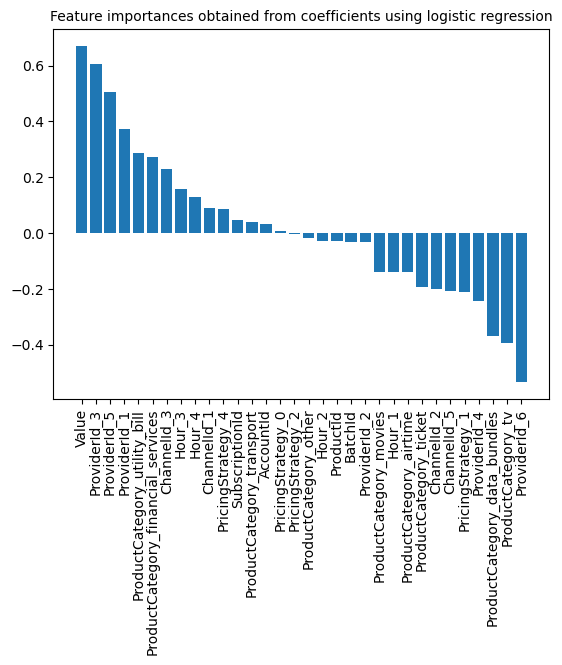

In [9]:
model = LogisticRegression()

X = df.drop(['Fraud'], axis=1)
y = df['Fraud']

ss = StandardScaler()
X__scaled = ss.fit_transform(X)

model.fit(X__scaled, y)

importances = pd.DataFrame(data={'Attribute': X.columns,'Importance': model.coef_[0]})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.title('Feature importances obtained from coefficients using logistic regression', size=10)
plt.xticks(rotation='vertical')
plt.show()

In [10]:

print (len(importances), "features, 15 most important are:")
# list 20 most important features
importances.head(15)

32 features, 15 most important are:


,Attribute,Importance
4,Value,0.669972
20,ProviderId_3,0.604002
22,ProviderId_5,0.505009
18,ProviderId_1,0.371593
13,ProductCategory_utility_bill,0.284851
7,ProductCategory_financial_services,0.273339
16,ChannelId_3,0.229452
30,Hour_3,0.157197
31,Hour_4,0.127462
14,ChannelId_1,0.090762


### New Dataframe with features to keep

In [11]:
# Creeate a list of features to keep
features_to_keep = importances['Attribute'][:15].tolist()

# Create a new dataframe with only the features to keep
df = df[features_to_keep]
# Add the target variable tto the dataframe
df['Fraud'] = y
# show dataframe
df.head()

# save the new dataframe to a csv file
df.to_csv('../../Data/training_clean.csv', index=False)

/var/folders/wj/ptff1vp12y59z_rr8m2h5r040000gn/T/ipykernel_29900/2365442490.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  features_to_keep = importances['Attribute'][:15].tolist()


# Prep data for validation

### Test Data import

In [12]:
df= pd.read_csv('../../Data/test.csv')
print ('shape of df :' ,  df.shape)
print(df.head())

shape of df : (45019, 15)
         TransactionId        BatchId       AccountId       SubscriptionId  \
0  TransactionId_50600  BatchId_35028  AccountId_2441  SubscriptionId_4426   
1  TransactionId_95109  BatchId_45139  AccountId_3439  SubscriptionId_2643   
2  TransactionId_47357  BatchId_74887  AccountId_4841  SubscriptionId_3829   
3  TransactionId_28185  BatchId_11025  AccountId_2685  SubscriptionId_4626   
4  TransactionId_22140  BatchId_29804  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_2857          UGX          256  ProviderId_5   ProductId_3   
1  CustomerId_3874          UGX          256  ProviderId_5  ProductId_15   
2  CustomerId_2857          UGX          256  ProviderId_4   ProductId_6   
3  CustomerId_3105          UGX          256  ProviderId_5  ProductId_10   
4  CustomerId_3105          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    ChannelId  Amount  Valu

In [13]:

# apply the same changes to the test data

# Text removal from cells
df['TransactionId'] = df['TransactionId'].str.split('_').str[1]
df['AccountId'] = df['AccountId'].str.split('_').str[1]
df['BatchId'] = df['BatchId'].str.split('_').str[1]
df['SubscriptionId'] = df['SubscriptionId'].str.split('_').str[1]
df['CustomerId'] = df['CustomerId'].str.split('_').str[1]
df['ProviderId'] = df['ProviderId'].str.split('_').str[1]
df['ProductId'] = df['ProductId'].str.split('_').str[1]
df['ChannelId'] = df['ChannelId'].str.split('_').str[1]

df.drop(useless_cols, axis=1, inplace=True)

# use TransactionId as index
df.set_index('TransactionId', inplace=True)

# Isolate Date and Time
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
df['Hour'] = df['TransactionStartTime'].dt.time
df.drop(['TransactionStartTime'], axis=1, inplace=True)

# Convert Time to int & only keep the hour, no minutes
df['Hour'] = df['Hour'].astype(str).str[:2].astype(int)

# Convert time into 4 categories; 4-11, 12-13, 14-19, 20-3
df['Hour'] = df['Hour'].apply(lambda x: 25 if x in range(0,4) else x)
df['Hour'] = df['Hour'].apply(lambda x: 1 if x in range(4,12) else x) 
df['Hour'] = df['Hour'].apply(lambda x: 2 if x in range(14,20) else x)
df['Hour'] = df['Hour'].apply(lambda x: 3 if x in range(12,14) else x)
df['Hour'] = df['Hour'].apply(lambda x: 25 if x in range(20,24) else x)
df['Hour'] = df['Hour'].apply(lambda x: 4 if x == 25 else x)

df = pd.get_dummies(df, columns=['ProductCategory'])
df = pd.get_dummies(df, columns=['ChannelId'])
df = pd.get_dummies(df, columns=['ProviderId'])
df = pd.get_dummies(df, columns=['PricingStrategy'])
df = pd.get_dummies(df, columns=['Hour'])

# Create a new dataframe with only the features to keep
df = df[features_to_keep]
# show dataframe
df.head()

# save the new dataframe to a csv file
df.to_csv('../../Data/test_clean.csv', index=False)